<a href="https://colab.research.google.com/github/wmok12/Thesis-research-minimumwage-employment/blob/main/Model_coding_construction_industry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading packages and data

In [18]:
pip install lime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=c3b8e27746fb7714975a6230c57a0c0a58473fccaa31fc00d04cd10c903fadae
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [35]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, mean_absolute_error, r2_score, make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, RandomizedSearchCV, ParameterGrid
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, LabelEncoder
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from xgboost import XGBClassifier

import matplotlib.pyplot as plt

import seaborn as sns

import shap

import lime
from lime.lime_tabular import LimeTabularExplainer


In [2]:
# Loading data
dataset = pd.read_csv('/content/drive/MyDrive/Thesis/Voorbereiding/cleaned_dataset_cps_construction.csv')

# Reference used libraries

In [39]:
import numpy
print('numpy:',numpy.__version__)

import pandas
print('pandas:', pandas.__version__)

import sklearn
print('sklearn:', sklearn.__version__)

import imblearn
print('imblearn', imblearn.__version__)

import xgboost
print('xgboost', xgboost.__version__)

import matplotlib
print('matplotlib', matplotlib.__version__)

import seaborn
print('seaborn', seaborn.__version__)

import scipy
print('scipy', scipy.__version__)

import lime
import shap


numpy: 1.26.4
pandas: 2.2.2
sklearn: 1.5.2
imblearn 0.12.4
xgboost 2.1.2
matplotlib 3.8.0
seaborn 0.13.2
scipy 1.13.1


AttributeError: module 'lime' has no attribute '__version__'

In [40]:
!pip show lime
!pip show shap


Name: lime
Version: 0.2.0.1
Summary: Local Interpretable Model-Agnostic Explanations for machine learning classifiers
Home-page: http://github.com/marcotcr/lime
Author: Marco Tulio Ribeiro
Author-email: marcotcr@gmail.com
License: BSD
Location: /usr/local/lib/python3.10/dist-packages
Requires: matplotlib, numpy, scikit-image, scikit-learn, scipy, tqdm
Required-by: 
Name: shap
Version: 0.46.0
Summary: A unified approach to explain the output of any machine learning model.
Home-page: 
Author: 
Author-email: Scott Lundberg <slund1@cs.washington.edu>
License: MIT License
Location: /usr/local/lib/python3.10/dist-packages
Requires: cloudpickle, numba, numpy, packaging, pandas, scikit-learn, scipy, slicer, tqdm
Required-by: 


# Data pre-processing

In [4]:
# Binary values
dataset['LABFORCE_binary'] = dataset['LABFORCE'].map({'In labor force': 1, 'Not labor force': 0})
dataset['SEX_binary'] = dataset['SEX'].map({'Male': 1, 'Female': 0})
dataset['CLASSWKR_binary'] = dataset['CLASSWKR'].map({'Self-employed': 1, 'Work for wages': 0})
dataset['EMPSTAT_binary'] = dataset['EMPSTAT'].map({'Unemployed': 1, 'Employed': 0})

# Split the dataset in X and y
X = dataset[['AGE', 'SEX_binary', 'MINIMUM WAGE', 'EDUC', 'CLASSWKR_binary', 'MARST', 'RACE', 'LABFORCE_binary']]
y = dataset['EMPSTAT_binary']

# Preprocessing
numerical_features = ['AGE','MINIMUM WAGE']
numerical_transformer = StandardScaler()

binary_features = ['SEX_binary', 'CLASSWKR_binary', 'LABFORCE_binary']

categorical_features_encode = ['MARST', 'RACE']
categorical_transformer_encode = OneHotEncoder(handle_unknown='ignore')

education_order = [['No schooling', 'Grades 1 t/m 4', 'Grades 5 or 6', 'Grades 7 or 8', 'Grade 9', 'Grade 10', 'Grade 11', 'Grade 12', 'High school diploma','Some college',  'AC degree, occupational program', 'AC degree, academic program', 'Bachelor\'s degree', 'Master/s degree', 'Professional school degree', 'Doctorate degree']]
categorical_features_label = ['EDUC']
categorical_transformer_label = OrdinalEncoder(categories = education_order)

preprocessor = ColumnTransformer(transformers=[
    ('cat_encode', categorical_transformer_encode, categorical_features_encode),
    ('cat_label', categorical_transformer_label, categorical_features_label),
    ('binary', 'passthrough', binary_features),
    ('num', numerical_transformer, numerical_features)
])

X = preprocessor.fit_transform(X)

# Get the feature names after preprocessing
feature_names = preprocessor.get_feature_names_out()

# Convert the transformed data back to DataFrames with proper feature names
X = pd.DataFrame(X, columns=feature_names)

# Split data into 80% training/validation data and 20% testing data
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Split data the training/validation data into 60% training data and 20% into validation data
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.2, random_state = 42)


# Logistic Regression (baseline) - addressing class imbalance

In [5]:
# RFE selector based on EDA
rfe_lr = RFE(estimator=LogisticRegression(max_iter=10000, random_state=42), n_features_to_select=2)

# Logistic regression pipeline
lr_model = ImbPipeline(steps=[
    ('feature_selection', rfe_lr),
    ('classifier', LogisticRegression(max_iter=10000, random_state=42))
])

# Setting parameters
lr_param_grid = {
    'classifier__solver': ['lbfgs', 'saga'],
    'classifier__penalty': ['l2', 'elasticnet'],
    'classifier__C': [0.1, 1],
    'classifier__class_weight': [
        {0: 1, 1: 2},
        {0: 1, 1: 3}
    ],
    'classifier__l1_ratio': [0.5]
}

# Filtering invalid parameter combinations
valid_params = []
for params in ParameterGrid(lr_param_grid):
    if params['classifier__penalty'] == 'elasticnet' and params['classifier__solver'] != 'saga':
        continue
    if params['classifier__penalty'] != 'elasticnet' and 'classifier__l1_ratio' in params:
        continue
    valid_params.append(params)

# K-Fold Cross-Validation
kf_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Scoring with weighted F1
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, pos_label=1),
    'recall': make_scorer(recall_score, pos_label=1),
    'f1_weighted': make_scorer(f1_score, average='weighted')
}

# GridSearchCV
lr_grid_search = GridSearchCV(
    estimator=lr_model,
    param_grid=lr_param_grid,
    cv=kf_cv,
    scoring=scoring,
    refit='f1_weighted',
    n_jobs=-1,
    verbose=3
)

# Train the model on the training data using GridSearchCV
lr_grid_search.fit(X_train, y_train)

#-------------------------------------------------------------------------------
# Results per fold
cv_results = pd.DataFrame(lr_grid_search.cv_results_)

# Columns for per fold scores
fold_columns = [col for col in cv_results.columns if "split" in col and "test_f1_weighted" in col]

# Best hyperparameters and scores per fold
best_params_per_fold = {}
for i, fold_col in enumerate(fold_columns):
    best_index = cv_results[fold_col].idxmax()
    best_params_per_fold[f"fold{i+1}"] = {
        "best_params": {param: cv_results.loc[best_index, param] for param in cv_results.columns if param.startswith("param_")},
        "best_score": cv_results.loc[best_index, fold_col]
    }

# Display the  best hyperparameters and scores per fold
print("Beste hyperparameters en scores per fold:")
for fold, result in best_params_per_fold.items():
    print(f"{fold}:")
    print(f"  Best Hyperparameters: {result['best_params']}")
    print(f"  Best Score: {result['best_score']:.4f}")

# Show the best final hyperparameters and score
print("Best hyperparameters:", lr_grid_search.best_params_)
print("Best accuracy:", lr_grid_search.best_score_)
print("Best precision:", lr_grid_search.cv_results_['mean_test_precision'][lr_grid_search.best_index_])
print("Best recall:", lr_grid_search.cv_results_['mean_test_recall'][lr_grid_search.best_index_])
print("Best F1-score:", lr_grid_search.cv_results_['mean_test_f1_weighted'][lr_grid_search.best_index_])

#-------------------------------------------------------------------------------
# Training data
# Make prediction on training data
lr_y_pred_train = lr_grid_search.best_estimator_.predict(X_train)

# Classification report for validation data
print("Classification report for Training data - LR")
print(classification_report(y_train, lr_y_pred_train))

# Validation data
# Make prediction on validation data
lr_y_pred_val = lr_grid_search.best_estimator_.predict(X_val)

# Classification report for validation data
print("Classification report for validation data - LR")
print(classification_report(y_val, lr_y_pred_val))

# Testing data
# Make prediction on testing data
lr_y_pred_test = lr_grid_search.best_estimator_.predict(X_test)

# Classification report for testing data
print("Classification report for testing data - LR")
print(classification_report(y_test, lr_y_pred_test))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
20 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/imblearn/pipeline.py", line 333, in fit
    self._final_estimator.fit(Xt, yt, **last_step_params["fit"])
  File "/usr/local/lib/py

Beste hyperparameters en scores per fold:
fold1:
  Best Hyperparameters: {'param_classifier__C': 0.1, 'param_classifier__class_weight': {0: 1, 1: 2}, 'param_classifier__l1_ratio': 0.5, 'param_classifier__penalty': 'l2', 'param_classifier__solver': 'lbfgs'}
  Best Score: 0.8980
fold2:
  Best Hyperparameters: {'param_classifier__C': 0.1, 'param_classifier__class_weight': {0: 1, 1: 2}, 'param_classifier__l1_ratio': 0.5, 'param_classifier__penalty': 'l2', 'param_classifier__solver': 'lbfgs'}
  Best Score: 0.8848
fold3:
  Best Hyperparameters: {'param_classifier__C': 0.1, 'param_classifier__class_weight': {0: 1, 1: 2}, 'param_classifier__l1_ratio': 0.5, 'param_classifier__penalty': 'l2', 'param_classifier__solver': 'lbfgs'}
  Best Score: 0.8935
fold4:
  Best Hyperparameters: {'param_classifier__C': 0.1, 'param_classifier__class_weight': {0: 1, 1: 2}, 'param_classifier__l1_ratio': 0.5, 'param_classifier__penalty': 'l2', 'param_classifier__solver': 'lbfgs'}
  Best Score: 0.8830
fold5:
  Best 

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


# Random Forest - no hyperparameter tuning

In [6]:
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

# Random Forest
rf_model = ImbPipeline(steps=[
    ('classifier', RandomForestClassifier(random_state = 42))
])

# Train random_search on the training data
rf_model.fit(X_train, y_train)

# Validation data
# Make prediction on validation data
rf_y_pred_val = rf_model.predict(X_val)

# Print classification report
print("Classification report for validation data - RF")
print(classification_report(y_val, rf_y_pred_val))

# Testing data
# Make prediction on testing data
rf_y_pred_test = rf_model.predict(X_test)

# Print classification report
print("Classification report for testing data - RF")
print(classification_report(y_test, rf_y_pred_test))

Classification report for validation data - RF
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      4464
           1       0.63      0.39      0.48       421

    accuracy                           0.93      4885
   macro avg       0.79      0.68      0.72      4885
weighted avg       0.92      0.93      0.92      4885

Classification report for testing data - RF
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      5525
           1       0.67      0.40      0.50       581

    accuracy                           0.92      6106
   macro avg       0.80      0.69      0.73      6106
weighted avg       0.91      0.92      0.92      6106



# Random Forest - addressing imbalance

In [7]:
# Make an RandomForestClassifier model
rf_model = RandomForestClassifier(random_state=42)

# Use RFE to take the top 2 selected features
rfe = RFE(estimator=rf_model, n_features_to_select=9)

# Random Forest
rf_pipeline = ImbPipeline(steps=[
    ('smote', SMOTE(random_state = 42)),
    ('feature_selection', rfe),
    ('classifier', rf_model)
])

# Train random_search on the training data
rf_pipeline.fit(X_train, y_train)

# Validation data
# Make prediction on validation data
rf_y_pred_val = rf_pipeline.predict(X_val)

# Print classification report
print("Classification report for validation data - RF")
print(classification_report(y_val, rf_y_pred_val))

# Testing data
# Make prediction on testing data
rf_y_pred_test = rf_pipeline.predict(X_test)

# Print classification report
print("Classification report for testing data - RF")
print(classification_report(y_test, rf_y_pred_test))

Classification report for validation data - RF
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      4464
           1       0.49      0.50      0.50       421

    accuracy                           0.91      4885
   macro avg       0.72      0.73      0.72      4885
weighted avg       0.91      0.91      0.91      4885

Classification report for testing data - RF
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      5525
           1       0.51      0.52      0.52       581

    accuracy                           0.91      6106
   macro avg       0.73      0.73      0.73      6106
weighted avg       0.91      0.91      0.91      6106



In [8]:
# Haal de RFE-stap op uit de pipeline, let op: gebruik rf_pipeline in plaats van rf_model
rfe_step = rf_pipeline.named_steps['feature_selection']

# De 'support_' attribute bevat een booleaanse array die aangeeft welke features geselecteerd zijn
selected_features_boolean = rfe_step.support_

# Haal de geselecteerde feature-namen op (gebruik de juiste feature-namen na preprocessing)
selected_feature_names = pd.Series(feature_names)[selected_features_boolean].tolist()

# Toon de geselecteerde features
print("Geselecteerde features door RFE:", selected_feature_names)


Geselecteerde features door RFE: ['cat_encode__MARST_Married', 'cat_encode__MARST_Never married', 'cat_encode__RACE_White', 'cat_label__EDUC', 'binary__SEX_binary', 'binary__CLASSWKR_binary', 'binary__LABFORCE_binary', 'num__AGE', 'num__MINIMUM WAGE']


# Random Forest - hyperparameter tuning random and gridsearch

In [9]:
# RandomForestClassifier model
rf_model = RandomForestClassifier(random_state=42)

# Use RFE to select the top 9 features
rfe = RFE(estimator=rf_model, n_features_to_select=9)

# Pipeline
rf_pipeline = ImbPipeline(steps=[
    ('smote', SMOTE(random_state = 42)),
    ('feature_selection', rfe),
    ('classifier', rf_model)
])

# K-Fold Cross-Validation
kf_cv = KFold(n_splits = 5, shuffle = True, random_state = 42)

# Scoring
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, pos_label = 1),
    'recall': make_scorer(recall_score, pos_label = 1),
    'f1_weighted': make_scorer(f1_score, average = "weighted")
}

rf_param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 5, 10],
    'classifier__class_weight': ['balanced',
     {0: 1, 1: 2},
     {0: 1, 1: 3}]
}


# GridSearchCV
rf_grid_search = GridSearchCV(
    estimator = rf_pipeline,
    param_grid = rf_param_grid,
    cv = kf_cv,
    scoring = scoring,
    refit = 'f1_weighted',
    n_jobs = -1,
    verbose = 1
)


# Train the model on the training data
rf_grid_search.fit(X_train, y_train)

#-------------------------------------------------------------------------------
# Results per fold
cv_results = pd.DataFrame(rf_grid_search.cv_results_)

# Columns for per-fold scores
fold_columns = [col for col in cv_results.columns if "split" in col and "test_f1" in col]

# For each fold finding the best hyperparameters
best_params_per_fold = {}
for i, fold_col in enumerate(fold_columns):
    best_index = cv_results[fold_col].idxmax()
    best_params_per_fold[f"fold {i+1}"] = {
        "best_params": {param: cv_results.loc[best_index, param] for param in cv_results.columns if param.startswith("param_")},
        "best_score": cv_results.loc[best_index, fold_col]
    }

# Display the best hyperparameters per fold
for fold, result in best_params_per_fold.items():
    print(f"{fold}:")
    print(f"  Best Hyperparameters: {result['best_params']}")
    print(f"  Best Weighted F1-Score: {result['best_score']:.4f}")

print("Best hyperparameters:", rf_grid_search.best_params_)
print("Best accuracy:", rf_grid_search.best_score_)
print("Best precision:", rf_grid_search.cv_results_['mean_test_precision'][rf_grid_search.best_index_])
print("Best recall:", rf_grid_search.cv_results_['mean_test_recall'][rf_grid_search.best_index_])
print("Best F1-score:", rf_grid_search.cv_results_['mean_test_f1_weighted'][rf_grid_search.best_index_])

#-------------------------------------------------------------------------------
# Training data
# Make prediction on validation data
rf_y_pred_train = rf_grid_search.predict(X_train)

# Print classification report
print("Classification report for training data - RF")
print(classification_report(y_train, rf_y_pred_train))

# Validation data
# Make prediction on validation data
rf_y_pred_val = rf_grid_search.predict(X_val)

# Print classification report
print("Classification report for validation data - RF")
print(classification_report(y_val, rf_y_pred_val))

# Testing data
# Make prediction on testing data
rf_y_pred_test = rf_grid_search.predict(X_test)

# Print classification report
print("Classification report for testing data - RF")
print(classification_report(y_test, rf_y_pred_test))

Fitting 5 folds for each of 18 candidates, totalling 90 fits
fold 1:
  Best Hyperparameters: {'param_classifier__class_weight': 'balanced', 'param_classifier__max_depth': None, 'param_classifier__n_estimators': 100}
  Best Weighted F1-Score: 0.9172
fold 2:
  Best Hyperparameters: {'param_classifier__class_weight': 'balanced', 'param_classifier__max_depth': None, 'param_classifier__n_estimators': 200}
  Best Weighted F1-Score: 0.9065
fold 3:
  Best Hyperparameters: {'param_classifier__class_weight': 'balanced', 'param_classifier__max_depth': None, 'param_classifier__n_estimators': 200}
  Best Weighted F1-Score: 0.9108
fold 4:
  Best Hyperparameters: {'param_classifier__class_weight': 'balanced', 'param_classifier__max_depth': None, 'param_classifier__n_estimators': 200}
  Best Weighted F1-Score: 0.9085
fold 5:
  Best Hyperparameters: {'param_classifier__class_weight': 'balanced', 'param_classifier__max_depth': None, 'param_classifier__n_estimators': 200}
  Best Weighted F1-Score: 0.9036

# Random forest with hyperparameter tuning without class imbalance

In [10]:
# RandomForestClassifier model
rf_model = RandomForestClassifier(random_state=42)

# Use RFE to select the top 9 features
rfe = RFE(estimator=rf_model, n_features_to_select=9)

# Pipeline
rf_pipeline = ImbPipeline(steps=[
    ('feature_selection', rfe),
    ('classifier', rf_model)
])

# General setting for RandomSearchCV en GridSearchCV
# K-Fold Cross-Validation
kf_cv = KFold(n_splits = 5, shuffle = True, random_state = 42)

# Scoring
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, pos_label = 1),
    'recall': make_scorer(recall_score, pos_label = 1),
    'f1_weighted': make_scorer(f1_score, average = "weighted")
}

rf_param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 5, 10]
}


# GridSearchCV
rf_grid_search_2 = GridSearchCV(
    estimator = rf_pipeline,
    param_grid = rf_param_grid,
    cv = kf_cv,
    scoring = scoring,
    refit = 'f1_weighted',
    n_jobs = -1,
    verbose = 1
)


# Train the model on the training data
rf_grid_search_2.fit(X_train, y_train)

#-------------------------------------------------------------------------------
# Results per fold
cv_results = pd.DataFrame(rf_grid_search_2.cv_results_)

# Columns for per-fold scores
fold_columns = [col for col in cv_results.columns if "split" in col and "test_f1" in col]

# For each fold finding the beste hyperparameters
best_params_per_fold = {}
for i, fold_col in enumerate(fold_columns):
    best_index = cv_results[fold_col].idxmax()
    best_params_per_fold[f"fold {i+1}"] = {
        "best_params": {param: cv_results.loc[best_index, param] for param in cv_results.columns if param.startswith("param_")},
        "best_score": cv_results.loc[best_index, fold_col]
    }

# Display the best hyperparameters per fold
for fold, result in best_params_per_fold.items():
    print(f"{fold}:")
    print(f"  Best Hyperparameters: {result['best_params']}")
    print(f"  Best Weighted F1-Score: {result['best_score']:.4f}")

print("Best hyperparameters:", rf_grid_search_2.best_params_)
print("Best accuracy:", rf_grid_search_2.best_score_)
print("Best precision:", rf_grid_search_2.cv_results_['mean_test_precision'][rf_grid_search_2.best_index_])
print("Best recall:", rf_grid_search_2.cv_results_['mean_test_recall'][rf_grid_search_2.best_index_])
print("Best F1-score:", rf_grid_search_2.cv_results_['mean_test_f1_weighted'][rf_grid_search_2.best_index_])

#-------------------------------------------------------------------------------
# Training data
# Make prediction on validation data
rf_y_pred_train = rf_grid_search_2.predict(X_train)

# Print classification report
print("Classification report for training data - RF")
print(classification_report(y_train, rf_y_pred_train))

# Validation data
# Make prediction on validation data
rf_y_pred_val = rf_grid_search_2.predict(X_val)

# Print classification report
print("Classification report for validation data - RF")
print(classification_report(y_val, rf_y_pred_val))

# Testing data
# Make prediction on testing data
rf_y_pred_test = rf_grid_search_2.predict(X_test)

# Print classification report
print("Classification report for testing data - RF")
print(classification_report(y_test, rf_y_pred_test))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
fold 1:
  Best Hyperparameters: {'param_classifier__max_depth': None, 'param_classifier__n_estimators': 200}
  Best Weighted F1-Score: 0.9303
fold 2:
  Best Hyperparameters: {'param_classifier__max_depth': None, 'param_classifier__n_estimators': 200}
  Best Weighted F1-Score: 0.9187
fold 3:
  Best Hyperparameters: {'param_classifier__max_depth': None, 'param_classifier__n_estimators': 200}
  Best Weighted F1-Score: 0.9192
fold 4:
  Best Hyperparameters: {'param_classifier__max_depth': None, 'param_classifier__n_estimators': 100}
  Best Weighted F1-Score: 0.9148
fold 5:
  Best Hyperparameters: {'param_classifier__max_depth': None, 'param_classifier__n_estimators': 200}
  Best Weighted F1-Score: 0.9153
Best hyperparameters: {'classifier__max_depth': None, 'classifier__n_estimators': 200}
Best accuracy: 0.9196448292247282
Best precision: 0.6326684630991268
Best recall: 0.3900573702545932
Best F1-score: 0.9196448292247282
Classifi

# Feature importance - RF

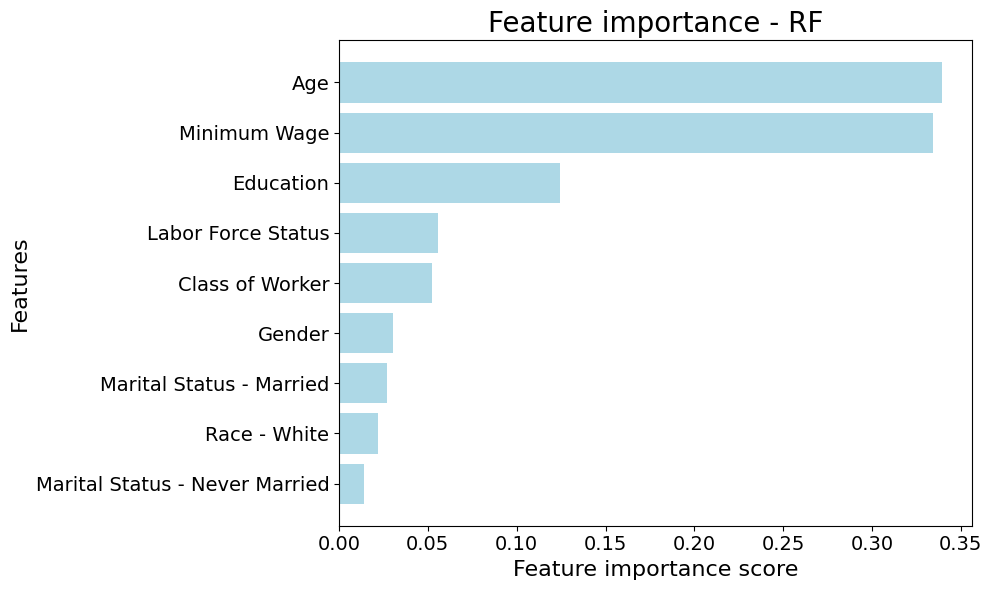

In [11]:
# changing the features to more readable names
feature_name_mapping = {
    'num__AGE': 'Age',
    'num__MINIMUM WAGE': 'Minimum Wage',
    'cat_label__EDUC': 'Education',
    'binary__LABFORCE_binary': 'Labor Force Status',
    'binary__CLASSWKR_binary': 'Class of Worker',
    'binary__SEX_binary': 'Gender',
    'cat_encode__MARST_Married': 'Marital Status - Married',
    'cat_encode__RACE_White': 'Race - White',
    'cat_encode__MARST_Never married': 'Marital Status - Never Married'
}

# Extract selected features from the fitted RFE
fitted_rfe = rf_grid_search.best_estimator_.named_steps['feature_selection']
fitted_rf = rf_grid_search.best_estimator_.named_steps['classifier']

# Get the selected feature names using RFE
selected_features = X_train.columns[fitted_rfe.support_]

# Get feature importances from the fitted RandomForestClassifier
feature_importances = fitted_rf.feature_importances_

# Sort the features and their importance scores
sorted_idx = np.argsort(feature_importances)
sorted_features = selected_features[sorted_idx]
sorted_importances = feature_importances[sorted_idx]

# Rename the features using the mapping dictionary
renamed_sorted_features = [feature_name_mapping.get(feat, feat) for feat in sorted_features]

# Create a horizontal bar chart for feature importances
plt.figure(figsize=(10, 6))
plt.barh(renamed_sorted_features, sorted_importances, color='#ADD8E6')
plt.xlabel('Feature importance score', fontsize = 16)
plt.ylabel('Features', fontsize = 16)
plt.title('Feature importance - RF', fontsize = 20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()


# Confusion matrix displayed as heatmap

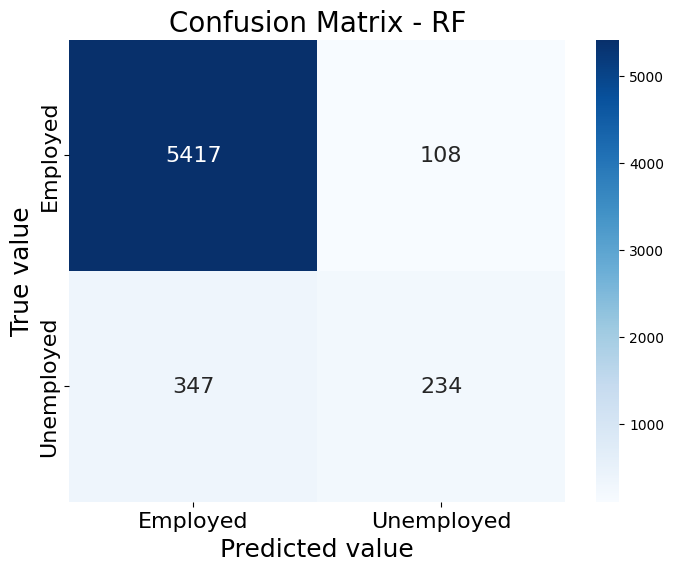

In [12]:
# Confusion matrix voor de testdata
conf_matrix = confusion_matrix(y_test, rf_y_pred_test)

# Plot de heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Employed', 'Unemployed'], yticklabels=['Employed', 'Unemployed'],annot_kws={"size": 16} )
plt.xlabel('Predicted value', fontsize=18)
plt.ylabel('True value', fontsize=18)
plt.title('Confusion Matrix - RF', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()


# Actual vs predicted - scatterplot

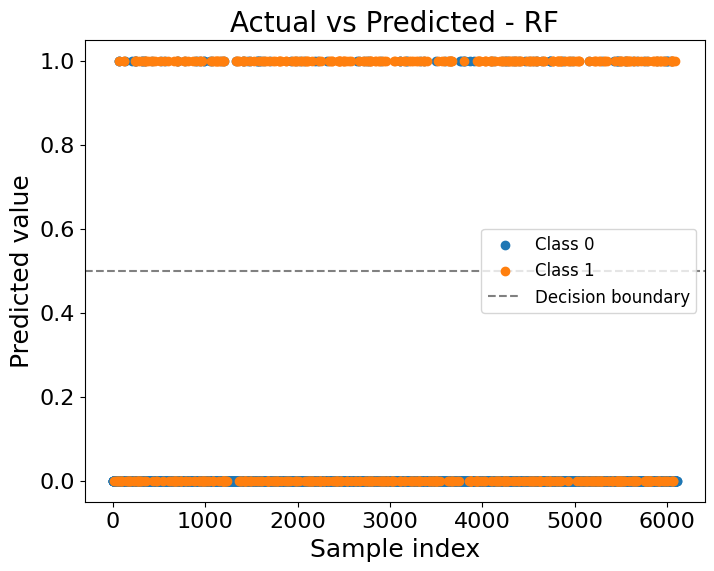

In [13]:
# actual vs predicted
actual = y_test
predicted = rf_y_pred_test

classes = np.unique(actual)

# Scatterplot
plt.figure(figsize=(8, 6))
for cls in classes:
    plt.scatter(
        np.where(actual == cls)[0],
        predicted[actual == cls],
        label=f"Class {cls}"
    )

plt.axhline(y=0.5, color="gray", linestyle="--", label="Decision boundary")
plt.xlabel("Sample index", fontsize=18)
plt.ylabel("Predicted value", fontsize=18)
plt.title("Actual vs Predicted - RF", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc="best", fontsize = 12)


# LIME

/usr/local/lib/python3.10/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.10/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.10/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

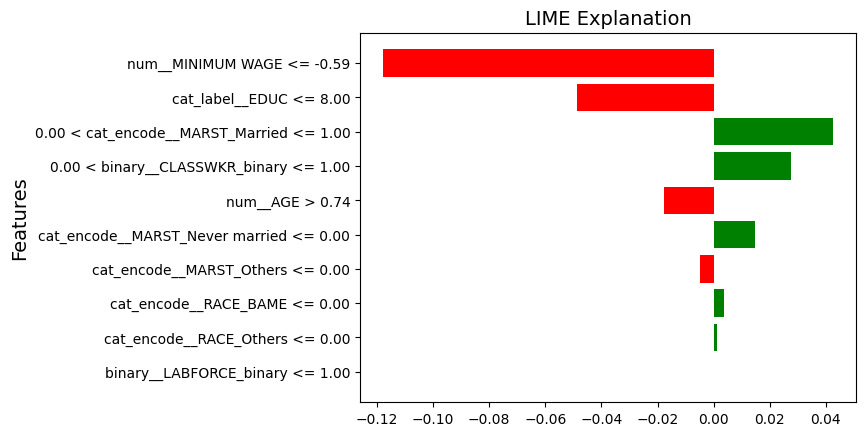

In [32]:
# Set the random seed for reproducibility
np.random.seed(42)
i = 10  # Fixed index from the validation set, choose a specific index like 10

# LIME explanation for RF without class imbalance
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=['class_0', 'class_1'],
    mode='classification'
)

exp = explainer.explain_instance(
    data_row=X_val.iloc[i],
    predict_fn=rf_grid_search_2.predict_proba,
    labels=[0]
)

# Display the explanation with matplotlib
fig = exp.as_pyplot_figure(label=0)

# Adjust the title to make it more readable
plt.title("LIME Explanation", fontsize = 14)
plt.ylabel("Features", fontsize = 14)

# Show the plot
plt.show()


/usr/local/lib/python3.10/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.10/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.10/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

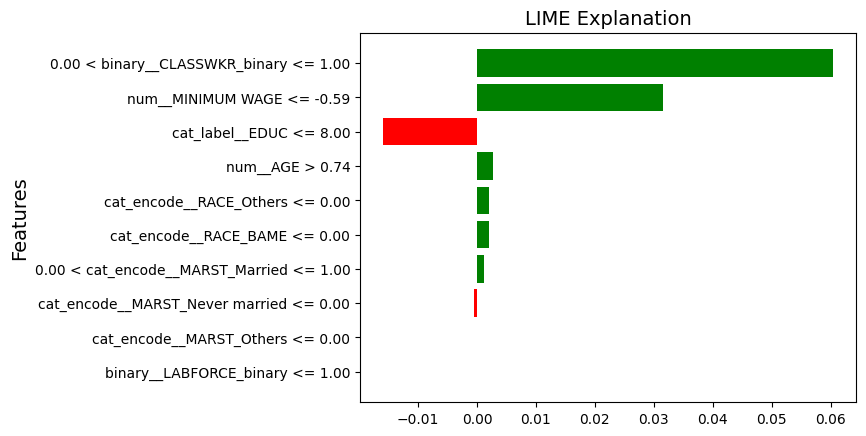

In [31]:
# Set the random seed for reproducibility
np.random.seed(42)
i = 10

# LIME explanation for RF with class imbalance
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=['class_0', 'class_1'],
    mode='classification'
)

exp = explainer.explain_instance(
    data_row=X_val.iloc[i],
    predict_fn=rf_grid_search.predict_proba,
    labels=[0]
)

# Display the explanation with matplotlib
fig = exp.as_pyplot_figure(label=0)

# Adjust the title and feature names to make it more readable
plt.title("LIME Explanation", fontsize = 14)
plt.ylabel("Features", fontsize = 14)

# Show the plot
plt.show()


# SHAP

In [ ]:
# Stap 1: Verkrijg de geselecteerde features via RFE
rfe_step = rf_grid_search_2.best_estimator_.named_steps['feature_selection']
selected_features = X_train.columns[rfe_step.support_]

# Stap 2: Neem een sample van 1000 rijen uit X_val en bijbehorende labels
sample_size = 4000
random_state = 42

X_val_sample = X_val.sample(n=sample_size, random_state=random_state)
y_val_sample = y_val.loc[X_val_sample.index]  # Zorg dat labels overeenkomen

# Stap 3: Filter de sampled data voor de geselecteerde features
X_val_selected = X_val_sample[selected_features]

# Stap 4: Maak de SHAP Explainer voor de classifier
explainer = shap.TreeExplainer(rf_grid_search_2.best_estimator_.named_steps['classifier'], feature_perturbation="interventional")

# Stap 5: Bereken SHAP waarden voor de sample
shap_values = explainer.shap_values(X_val_selected)

In [ ]:
# SHAP Summary Plot als bar chart
shap.summary_plot(
    shap_values,
    features=X_val_selected,
    feature_names=selected_features,
    plot_type="bar",
    plot_size=(20, 50)  # Pas de grootte van de grafiek aan
)


# XGBoost - without hyperparameter tuning

In [ ]:
# eXtreme Gradient Boosting (XGBoost)

xgb_model = ImbPipeline(steps=[
    ('classifier',XGBClassifier(random_state = 42))
])

# Train the model on the training data
xgb_model.fit(X_train, y_train)

# Validation data
# Make prediction on validation data
xgb_y_pred_val = xgb_model.predict(X_val)

# Create a DataFrame for actual vs predicted values
a = pd.DataFrame({'Actual value': y_val, 'Predicted value': xgb_y_pred_val})
print(a.head())

# Print classification report
print("Classification report for validation data - XGBoost")
print(classification_report(y_val, xgb_y_pred_val))

# Testing data
# Make prediction on testing data
xgb_y_pred_test = xgb_model.predict(X_test)

# Create a DataFrame for actual vs predicted values
a = pd.DataFrame({'Actual value': y_test, 'Predicted value': xgb_y_pred_test})
print(a.head())

# Print classification report
print("Classification report for testing data - XGBoost")
print(classification_report(y_test, xgb_y_pred_test))


# XGBoost - adressing class imbalance

In [ ]:
# eXtreme Gradient Boosting (XGBoost)
# Make the model
xgb_model = XGBClassifier(random_state = 42)

# Using RFE
rfe_xgb = RFE(estimator = xgb_model, n_features_to_select = 11)

xgb_pipeline = ImbPipeline(steps=[
    ('smote', SMOTE(random_state = 42)),
    ('feature selection', rfe_xgb),
    ('classifier', xgb_model)
])

# Train the model on the training data
xgb_pipeline.fit(X_train, y_train)

# Validation data
# Make prediction on validation data
xgb_y_pred_val = xgb_pipeline.predict(X_val)

# Create a DataFrame for actual vs predicted values
a = pd.DataFrame({'Actual value': y_val, 'Predicted value': xgb_y_pred_val})
print(a.head())

# Print classification report
print("Classification report for validation data - XGBoost")
print(classification_report(y_val, xgb_y_pred_val))

# Testing data
# Make prediction on testing data
xgb_y_pred_test = xgb_pipeline.predict(X_test)

# Create a DataFrame for actual vs predicted values
a = pd.DataFrame({'Actual value': y_test, 'Predicted value': xgb_y_pred_test})
print(a.head())

# Print classification report
print("Classification report for testing data - XGBoost")
print(classification_report(y_test, xgb_y_pred_test))


# XGBoost - hyperparameter tuning

In [ ]:
# eXtreme Gradient Boosting (XGBoost)
# Make the model
xgb_model = XGBClassifier(random_state = 42)

# Using RFE to select the op 11
rfe_xgb = RFE(estimator = xgb_model, n_features_to_select = 11)

xgb_pipeline = ImbPipeline(steps=[
    ('smote', SMOTE(random_state = 42)),
    ('feature selection', rfe_xgb),
    ('classifier', xgb_model)
])

# Hyperparameter tuning with GridSearchCV
xgb_param_grid = {'classifier__n_estimators': [100, 200],
              'classifier__max_depth': [3, 5, 7],
              'classifier__scale_pos_weight': [1, 3]
}

# K-Fold Cross-Validation
kf_cv = KFold(n_splits = 5, shuffle = True, random_state = 42)

# Scoring
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, pos_label = 1),
    'recall': make_scorer(recall_score, pos_label = 1),
    'f1_weighted': make_scorer(f1_score, average = "weighted")
}

# GridSearchCV
xgb_grid_search = GridSearchCV(
    estimator = xgb_pipeline,
    param_grid = xgb_param_grid,
    cv = kf_cv,
    scoring = scoring,
    refit = 'f1_weighted',
    n_jobs = -1,
    verbose = 3
)

# Train the model on the training data
xgb_grid_search.fit(X_train, y_train)

#-------------------------------------------------------------------------------

# Results per fold
cv_results = pd.DataFrame(xgb_grid_search.cv_results_)

# Columns for per-fold scores
fold_columns = [col for col in cv_results.columns if "split" in col and "test_f1" in col]

# For each fold finding the beste hyperparameters
best_params_per_fold = {}
for i, fold_col in enumerate(fold_columns):
    best_index = cv_results[fold_col].idxmax()
    best_params_per_fold[f"fold {i+1}"] = {
        "best_params": {param: cv_results.loc[best_index, param] for param in cv_results.columns if param.startswith("param_")},
        "best_score": cv_results.loc[best_index, fold_col]
    }

# Display the best hyperparameters per fold
for fold, result in best_params_per_fold.items():
    print(f"{fold}:")
    print(f"  Best Hyperparameters: {result['best_params']}")
    print(f"  Best Weighted F1-Score: {result['best_score']:.4f}")

print("Best hyperparameters:", xgb_grid_search.best_params_)
print("Best accuracy:", xgb_grid_search.best_score_)
print("Best precision:", xgb_grid_search.cv_results_['mean_test_precision'][xgb_grid_search.best_index_])
print("Best recall:", xgb_grid_search.cv_results_['mean_test_recall'][xgb_grid_search.best_index_])
print("Best F1-score:", xgb_grid_search.cv_results_['mean_test_f1_weighted'][xgb_grid_search.best_index_])

#-------------------------------------------------------------------------------
# Training data
# Make prediction on validation data
xgb_y_pred_train = xgb_grid_search.predict(X_train)

# Print classification report
print("Classification report for validation data - XGBoost")
print(classification_report(y_train, xgb_y_pred_train))

# Validation data
# Make prediction on validation data
xgb_y_pred_val = xgb_grid_search.predict(X_val)

# Print classification report
print("Classification report for validation data - XGBoost")
print(classification_report(y_val, xgb_y_pred_val))

# Testing data
# Make prediction on testing data
xgb_y_pred_test = xgb_grid_search.predict(X_test)

# Print classification report
print("Classification report for testing data - XGBoost")
print(classification_report(y_test, xgb_y_pred_test))


# Feature importance - XGBoost

In [ ]:
# Changing the features to more readable names
feature_name_mapping = {
    'num__AGE': 'Age',
    'num__MINIMUM WAGE': 'Minimum Wage',
    'cat_label__EDUC': 'Education',
    'binary__LABFORCE_binary': 'Labor Force Status',
    'binary__CLASSWKR_binary': 'Class of Worker',
    'binary__SEX_binary': 'Gender',
    'cat_encode__MARST_Married': 'Marital Status - Married',
    'cat_encode__RACE_White': 'Race - White',
    'cat_encode__MARST_Never married': 'Marital Status - Never Married',
    'cat_encode__RACE_Others': 'Race - others',
    'cat_encode__RACE_BAME': 'Race - BAME'
}

# Access the fitted RFE and XGBClassifier from the pipeline
fitted_rfe = xgb_grid_search.best_estimator_.named_steps['feature selection']
fitted_xgb = xgb_grid_search.best_estimator_.named_steps['classifier']

# Get the selected features based on RFE
selected_features = X_train.columns[fitted_rfe.support_]

# Rename the features using the mapping dictionary
renamed_features = [feature_name_mapping.get(feat, feat) for feat in selected_features]

# Get feature importances from the XGBClassifier (for selected features)
feature_importances = fitted_xgb.feature_importances_

# Sort feature importances for better visualization
sorted_idx = np.argsort(feature_importances)
sorted_importances = feature_importances[sorted_idx]
sorted_renamed_features = [renamed_features[idx] for idx in sorted_idx]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(sorted_renamed_features, sorted_importances, color='#ADD8E6')
plt.xlabel('Feature importance score', fontsize=16)
plt.ylabel('Features', fontsize =16)
plt.title('Feature importance - XGBoost', fontsize = 20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()


# Confusion matrix displayed as heatmap

In [ ]:
# Confusion matrix for the test data
conf_matrix = confusion_matrix(y_test, xgb_y_pred_test)

# Plot de heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Employed', 'Unemployed'], yticklabels=['Employed', 'Unemployed'],annot_kws={"size": 16} )
plt.xlabel('Predicted value', fontsize=18)
plt.ylabel('True value', fontsize=18)
plt.title('Confusion Matrix - XGBoost', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()


# Actual vs predicted - scatterplot

In [ ]:
# Actual vs predicted
actual = y_test
predicted = xgb_y_pred_test

classes = np.unique(actual)

# Scatterplot
plt.figure(figsize=(8, 6))
for cls in classes:
    plt.scatter(
        np.where(actual == cls)[0],
        predicted[actual == cls],
        label=f"Class {cls}"
    )

plt.axhline(y=0.5, color="gray", linestyle="--", label="Decision boundary")
plt.xlabel("Sample index", fontsize=18)
plt.ylabel("Predicted value", fontsize=18)
plt.title("Actual vs Predicted - XGBoost", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc="best", fontsize = 12)
